## 0. Load the environment variables

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

import os
import yaml

with open(r"gemini_key_gtm.yaml", 'r') as file:
    api_creds = yaml.safe_load(file)
os.environ["GOOGLE_API_KEY"] = api_creds['gemini_key']

## 1. Import Required Libraries

In [2]:
import base64
import streamlit as st
from PIL import Image
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage
from langchain.agents import Tool, initialize_agent
from langchain_google_genai import ChatGoogleGenerativeAI
import sqlite3
from datetime import datetime
import json
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Initialize LLM Model

In [3]:
# Initialize LLM
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

## 3. SQLite Memory Implementation

In [ ]:
# Custom Memory Implementation using SQLite
class SQLiteMemory:
    def __init__(self, db_path="memory/memory.db"):
        self.conn = sqlite3.connect(db_path, check_same_thread=False)
        self.create_tables()

    def create_tables(self):
        cursor = self.conn.cursor()
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS conversations (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                user_id TEXT NOT NULL,
                content TEXT NOT NULL,
                timestamp DATETIME DEFAULT CURRENT_TIMESTAMP,
                metadata TEXT
            )
        """)
        self.conn.commit()

    def store(self, data):
        cursor = self.conn.cursor()
        cursor.execute(
            "INSERT INTO conversations (user_id, content, metadata) VALUES (?, ?, ?)",
            (data["thread_id"], data["content"], json.dumps(data.get("metadata", {})))
        )
        self.conn.commit()

    def get_by_thread_id(self, thread_id):
        cursor = self.conn.cursor()
        cursor.execute(
            "SELECT content, timestamp, metadata FROM conversations WHERE user_id = ? ORDER BY timestamp DESC",
            (thread_id,)
        )
        results = cursor.fetchall()
        return [
            {
                "content": content,
                "timestamp": timestamp,
                "metadata": json.loads(metadata)
            }
            for content, timestamp, metadata in results
        ]

    def close(self):
        self.conn.close()

# Initialize Memory
memory = SQLiteMemory()

## 4. Memory Management Functions

In [5]:
# Function to save conversation
def save_conversation(user_id, conversation):
    memory.store({
        "thread_id": user_id,
        "content": conversation,
        "metadata": {
            "timestamp": datetime.now().isoformat()
        }
    })

# Function to retrieve conversation history
def retrieve_conversation(user_id):
    return memory.get_by_thread_id(user_id)

## 5. Memory Retrieval Tools

In [6]:
# Memory Retrieval Tool: extracts past diagnoses from stored conversation history
def memory_retrieval_tool_prev(query: str, user_id: str) -> str:
    conversation_history = retrieve_conversation(user_id)
    if not conversation_history:
        return "No past medical history available."
    # Combine past conversation texts
    combined_text = "\n".join([item["content"] for item in conversation_history])
    # Use the LLM to summarize and extract relevant diagnoses
    prompt = (
        f"Below are past medical records. Extract and summarize any diagnoses or relevant medical conditions mentioned "
        f"that relate to the query: '{query}'.\n\nRecords:\n{combined_text}\n\nSummary:"
    )
    summary = llm.invoke([HumanMessage(content=prompt)])
    return summary

def memory_retrieval_tool(query: str, user_id: str) -> str:
    conversation_history = retrieve_conversation(user_id)
    if not conversation_history:
        return "No past conversations available."
    
    # Combine all previous conversations
    combined_text = "\n".join([f"- {item['timestamp']}: {item['content']}" for item in conversation_history])

    # Modify the prompt to summarize the entire conversation history
    summary_prompt = f"""
		You are an AI assistant summarizing previous user conversations. Focus only on the discussions between the user and the AI. Do not mention system
		functions, tools, or implementation details. 
		
		Here is the conversation history:
		
		{combined_text}
		
		Summarize the key points discussed so far in simple, clear language for the user.
		"""
    
    summary = llm.invoke([HumanMessage(content=summary_prompt)])
    return summary

## 6. ReAct Agent

In [7]:
# Agent Query Function using LangChain's Agent Executor
def agent_query(user_query: str, user_id: str) -> str:
    # Define the tools for the agent
    tools = [
        Tool(
            name="MemoryRetrieval",
            func=lambda q: memory_retrieval_tool_prev(q, user_id),
            description="Retrieves and summarizes past diagnoses from stored medical records."
        ),
        
        Tool(
            name="LLMResponse",
            func=lambda q: llm.invoke([HumanMessage(content=q)]),
            description="Generates a human-like response using the LLM."
        )
    ]
    # Initialize the agent with a ReAct strategy. The agent will decide which tool(s) to use.
    agent = initialize_agent(tools, llm, agent="zero-shot-react-description", verbose=True)
    result = agent.run(user_query)
    return result

## 7. Image Processing Functions

In [8]:
def process_image_file(image_path):
    try:
        with open(image_path, "rb") as image_file:
            image_content = image_file.read()
            base64_image = base64.b64encode(image_content).decode('utf-8')
            
            # Display the image
            image = Image.open(image_path)
            plt.figure(figsize=(10, 8))
            plt.imshow(image)
            plt.axis('off')
            plt.title('Medical Image for Analysis')
            plt.show()

            return base64_image
    except Exception as e:
        print(f"Error processing image: {e}")
        return None
    
def analyze_medical_image(base64_image, patient_symptoms):

    message = HumanMessage(
            content=[
                {"type": "text", "text": f"""Analyze the following medical image and provide **only** the key observations:
                - Correlate findings with patient symptoms: {patient_symptoms}
                - Identify observed abnormalities
                - Suggest possible conditions
                - Indicate affected organs
                - Propose prevention strategies (if applicable)
                🚫 **DO NOT** include:
                - Formal document elements (e.g., "Physician Name", "Signature")
                - Assumptions beyond what can be inferred from the image
                - General disclaimers or irrelevant text
                Keep the response **detailed, structured, and strictly medical**.
                """},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}
                }
            ]
        )
    
    # Invoke the LLM with the message
    image_insights = llm.invoke([message])
    return image_insights

## 8. Medical Report Generation

In [9]:
def generate_medical_report(patient_details, image_insights):

        report_prompt = PromptTemplate(
            template="""Based on the following details, generate a **detailed, structured medical report**:
            1. **Patient Details:** {patient_details}
            2. **Image Insights:** {image_insights}

            **Your report should include:
            - **Patient summary** (brief overview)
            - **Observed abnormalities** (with medical relevance)
            - **Possible conditions/diagnosis**
            - **Recommendations or next steps** (if applicable)

            🚫 **DO NOT** include:
            - Physician name, signature, or formal document headers
            - Extra disclaimers or non-medical text
            - Assumptions not supported by findings

            **Report:**
            """,
            input_variables=["patient_details", "image_insights"],
        )
        
        # Create the LLM chain for generating the report
        report_chain = LLMChain(llm=llm, prompt=report_prompt)
        full_report = report_chain.run(patient_details=patient_details, image_insights=str(image_insights))
        
        return full_report

## 9. Test the Medical Analysis Workflow

In [10]:
def medical_analysis(image_path, patient_name, patient_age, patient_gender, patient_symptoms, user_id):

        print("=" * 60)
        print("🏥 MEDICAL IMAGE ANALYSIS REPORT")
        print("=" * 60)
        
        # Process the image
        print("📸 Processing medical image...")
        base64_image = process_image_file(image_path)
        
        if not base64_image:
            print("❌ Failed to process image")
            return
        
        # Patient details
        patient_details = f"Name: {patient_name}, Age: {patient_age}, Gender: {patient_gender}, Symptoms: {patient_symptoms}"
        
        print("\n👤 Patient Information:")
        print(patient_details)
        
        # Analyze the image
        print("\n🔍 Analyzing medical image...")
        image_insights = analyze_medical_image(base64_image, patient_symptoms)
        
        print("\n📋 Image Analysis Results:")
        print(str(image_insights))
        
        # Generate comprehensive report
        print("\n📄 Generating comprehensive medical report...")
        full_report = generate_medical_report(patient_details, image_insights)
        
        print("\n" + "=" * 60)
        print("📄 COMPREHENSIVE MEDICAL REPORT")
        print("=" * 60)
        print(full_report)
        
        # Save to memory
        conversation_entry = f"""
        ### Patient Information",
        {patient_details}
        ### Image Analysis
        {str(image_insights)}
        ### Medical Report
        {full_report}
        """
        
        save_conversation(user_id, conversation_entry)
        print("\n💾 Analysis saved to patient history")
        
        return {
            "patient_details": patient_details,
            "image_insights": str(image_insights),
            "full_report": full_report
        }

## 10. Utility Functions

In [11]:
def display_conversation_history(user_id):

    conversation_history = retrieve_conversation(user_id)
        
    if not conversation_history:
        print(f"No conversation history found for user: {user_id}")
        return
        
    print(f"\n📚 Conversation History for User: {user_id}")
    print("=" * 50)
        
    for i, item in enumerate(reversed(conversation_history), 1):
        print(f"\\n🕒 Entry {i} - Timestamp: {item['timestamp']}")
        print("-" * 30)
        print(item["content"])
        print("-" * 30)
    
def save_history_to_file(user_id, filename=None):
    
    conversation_history = retrieve_conversation(user_id)
        
    if not conversation_history:
        print(f"No conversation history found for user: {user_id}")
        return
        
    if filename is None:
        filename = f"{user_id}_medical_history.txt"
        
    download_data = "\n\n---\n\n".join([
        f"Timestamp: {item['timestamp']}\n\n{item['content']}"
        for item in conversation_history
    ])
        
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(download_data)
        
    print(f"✅ Conversation history saved to: {filename}")
    
def query_agent(user_query, user_id):
    
    print(f"🤖 Processing query: {user_query}")
    print("-" * 40)
        
    agent_response = agent_query(user_query, user_id)
        
    print("\n🤖 Agent Response:")
    print("=" * 40)
    print(agent_response)
        
    # Save the agent interaction
    save_conversation(user_id, f"**Agent Query:** {user_query}\n\n**Agent Response:** {agent_response}")
    print("\n💾 Query and response saved to history")
        
    return agent_response

## 11. Example Usage

🏥 Medical Image Analysis System Ready!
🏥 MEDICAL IMAGE ANALYSIS REPORT
📸 Processing medical image...


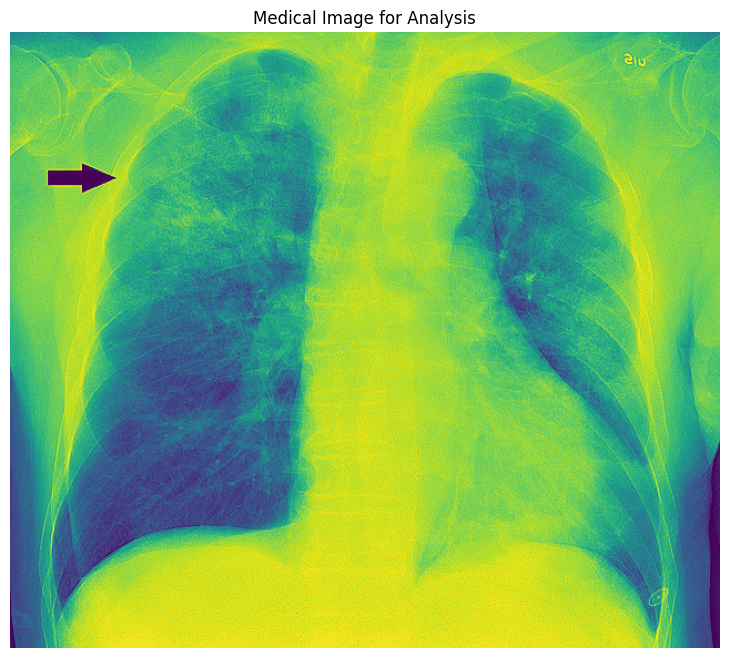


👤 Patient Information:
Name: John Doe, Age: 45, Gender: Male, Symptoms: Shortness of breath, persistent cough

🔍 Analyzing medical image...

📋 Image Analysis Results:
content="**Key Observations:**\n\n*   **Right Lung Opacity:** Significant, diffuse opacity is present in the right lung, predominantly in the upper lobe. This opacity exhibits a heterogeneous pattern.\n*   **Possible Cavitation:** Areas of lucency within the opacity suggest possible cavitation.\n*   **Left Lung:** The left lung appears relatively clear.\n*   **Heart Size:** The heart size appears within normal limits.\n*   **Mediastinum:** The mediastinum appears unremarkable.\n\n**Correlation with Symptoms:**\n\n*   The right lung opacity is consistent with the patient's reported shortness of breath and persistent cough. This suggests impaired gas exchange and airway irritation.\n\n**Possible Conditions:**\n\n*   **Infectious Pneumonia:** Given the opacity and patient symptoms, an infectious pneumonia (bacterial, fungal

In [ ]:
# Set up patient information
USER_ID = "patient_101"
PATIENT_NAME = "John Doe"
PATIENT_AGE = 45
PATIENT_GENDER = "Male"
PATIENT_SYMPTOMS = "Shortness of breath, persistent cough"

# Path to your medical image
IMAGE_PATH = r"Chest_radiograph.jpg"

print("🏥 Medical Image Analysis System Ready!")

# To analyze a medical image, use:
print(medical_analysis(IMAGE_PATH, PATIENT_NAME, PATIENT_AGE, PATIENT_GENDER, PATIENT_SYMPTOMS, USER_ID))

In [14]:
# To query the agent
print(query_agent('what diagnosis did i have in past', USER_ID))

🤖 Processing query: what diagnosis did i have in past
----------------------------------------


> Entering new AgentExecutor chain...


C:\Users\sunilvarmap\AppData\Local\Temp\ipykernel_21908\472772708.py:18: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(tools, llm, agent="zero-shot-react-description", verbose=True)


I need to access the patient's medical records to retrieve past diagnoses.
Action: MemoryRetrieval
Action Input: "Retrieve and summarize past diagnoses from medical records."
Observation: content='John Doe, a 45-year-old male, presents with shortness of breath and persistent cough.  Imaging reveals a significant opacity in the right lung, predominantly in the upper lobe, with possible cavitation.  Possible diagnoses include:\n\n*   Infectious Pneumonia (bacterial, fungal, or viral, including possible *Mycobacterium tuberculosis*)\n*   Lung Abscess (if cavitation is confirmed)\n*   Malignancy (bronchogenic carcinoma with secondary infection, less likely)\n*   Aspiration Pneumonia (if the patient has a history of aspiration)' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--f89704cd-ec81-4929-93db-018b729877be-0' usage_metadata={'input_tokens': 11

In [ ]:
# To query the agent
print(query_agent('what precautionary measures do a patient need to take if he has pnemonia', USER_ID))

🤖 Processing query: what precausive measures do a patient need to take if he has pnemonia
----------------------------------------


> Entering new AgentExecutor chain...
This question requires medical knowledge about pneumonia. I should use the LLM to get a comprehensive answer about precautionary measures for pneumonia patients.
Action: LLMResponse
Action Input: "What precautionary measures should a patient take if they have pneumonia?"
Observation: content="If you have pneumonia, taking the following precautionary measures is crucial to help you recover, prevent complications, and avoid spreading the infection:\n\n**1. Follow Your Doctor's Instructions Meticulously:**\n\n*   **Medication:**  Take all prescribed medications (antibiotics, antivirals, antifungals, bronchodilators, etc.) exactly as directed by your doctor. Do not skip doses or stop taking the medication early, even if you start feeling better. This is vital for completely eradicating the infection and preventing antibio

In [16]:
# To view conversation history, use:
print(display_conversation_history(USER_ID))


📚 Conversation History for User: patient_101
\n🕒 Entry 1 - Timestamp: 2025-06-01 13:56:10
------------------------------

        ### Patient Information",
        Name: John Doe, Age: 45, Gender: Male, Symptoms: Shortness of breath, persistent cough
        ### Image Analysis
        content="**Key Observations:**\n\n*   **Right Lung Opacity:** Significant, diffuse opacity is present in the right lung, predominantly in the upper lobe. This opacity exhibits a heterogeneous pattern.\n*   **Possible Cavitation:** Areas of lucency within the opacity suggest possible cavitation.\n*   **Left Lung:** The left lung appears relatively clear.\n*   **Heart Size:** The heart size appears within normal limits.\n*   **Mediastinum:** The mediastinum appears unremarkable.\n\n**Correlation with Symptoms:**\n\n*   The right lung opacity is consistent with the patient's reported shortness of breath and persistent cough. This suggests impaired gas exchange and airway irritation.\n\n**Possible Conditions